# Preparations

Install

In [ ]:
%tensorflow_version 1.x
!pip install typer

TensorFlow 1.x selected.


Imports

In [ ]:
import os
import cv2
import pickle
import numpy as np

from PIL import Image
from pathlib import Path
from google.colab.patches import cv2_imshow

Create directories for images

In [ ]:
!mkdir initial
!mkdir aligned
!mkdir siblings
!mkdir output

**Now you can put input images in the *'initial'* folder**

Clone the StyleGAN2 repo

In [ ]:
!git clone https://github.com/justinpinkney/stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (141/141), done.


# Load models

**Specify the path:**

In [ ]:
%%shell
cd /content
gdown https://drive.google.com/uc?id=1oXIKqVjJLOb-V0UNEjiwQdVOm1whMkJX&
unzip pretrained.zip

gdown https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
unzip input.zip -d initial/

unzip:  cannot find or open pretrained.zip, pretrained.zip.zip or pretrained.zip.ZIP.
Downloading...
From: https://drive.google.com/uc?id=1oXIKqVjJLOb-V0UNEjiwQdVOm1whMkJX
To: /content/pretrained.zip
80.2MB [00:00, 257MB/s]Downloading...
From: https://drive.google.com/uc?id=1l4HebC6VUeUaCFD-EPCY4aPveKJaSClH
To: /content/input.zip
2.36MB [00:00, 57.7MB/s]
106MB [00:00, 257MB/s] Archive:  input.zip
563MB [00:02, 235MB/s]


CalledProcessError: ignored

In [ ]:
!unzip pretrained.zip


Archive:  pretrained.zip
replace pretrained/blended M1 (32, 64, 128).pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pretrained/blended M1 (32, 64, 128).pkl  
  inflating: pretrained/blended M5 (64, 128).pkl  


In [ ]:
# Path to the toonification model
# (e.g. 'blended M1 (32, 64, 128).pkl' or 'blended M5 (64, 128).pkl')
toon_path = '/content/pretrained/blended M1 (32, 64, 128).pkl'

Read toonification model

In [ ]:
%cd /content/stylegan2

import pretrained_networks

_, _, Gs_toon = pretrained_networks.load_networks(toon_path)

%cd /content

/content/stylegan2
/content


# Prepare the images

Align images

In [ ]:
!python stylegan2/align_images.py initial aligned

64045056/64040097 [==============================] - 2s 0us/step


*Find* siblings in FFHQ space

In [ ]:
!python stylegan2/project_images.py --network-pkl "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/table2/stylegan2-ffhq-config-e-Gorig-Dorig.pkl" --num-steps 1000 aligned siblings

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/table2/stylegan2-ffhq-config-e-Gorig-Dorig.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "0_orig_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "2_orig_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "36_01.png"...
Loading images from ".styl

# Toonify

In [ ]:
from stylegan2.dnnlib import tflib

# Filenames of latent codes
latent_dir = Path("siblings")
latents = latent_dir.glob("*.npy")

for latent_file in latents:
    latent = np.load(latent_file)
    latent = np.expand_dims(latent, axis=0)
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
    images = Gs_toon.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
    Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(os.path.join('output', os.path.split(latent_file)[1][:-3] + 'jpg'))

# Display the results (optional)

In [ ]:
grid = None
headers = []

Function to build a grid row of images in the path

In [ ]:
def add_grid_row(path, header, endings=('*_01.png', '*_01.jpg')):
    global grid

    path = Path(path)
    print(path)
    filenames = []
    for ending in endings:
        filenames += [str(file) for file in path.glob(ending)]
    filenames = sorted(filenames)

    for i_file, file in enumerate(filenames):
        img = cv2.imread(file)
        img = cv2.resize(img, (200, 200))

        if i_file == 0:
            final_img = img
        else:
            final_img = np.concatenate((final_img, img), axis=0)

    if grid is None:
        # First row
        grid = final_img
    else:
        # Next row
        grid = np.concatenate((grid, final_img), axis=1)
    
    # Add the header
    headers.append(header)

Build the grid

In [ ]:
# 1 - aligned initial images
add_grid_row(path='aligned', header='Initial')
# 2 - siblings
add_grid_row(path='siblings', header='Sibling')
# Add images to the grid
add_grid_row(path='output', header='toonified')

aligned
siblings
output


Display

['Initial', 'Sibling', 'toonified']


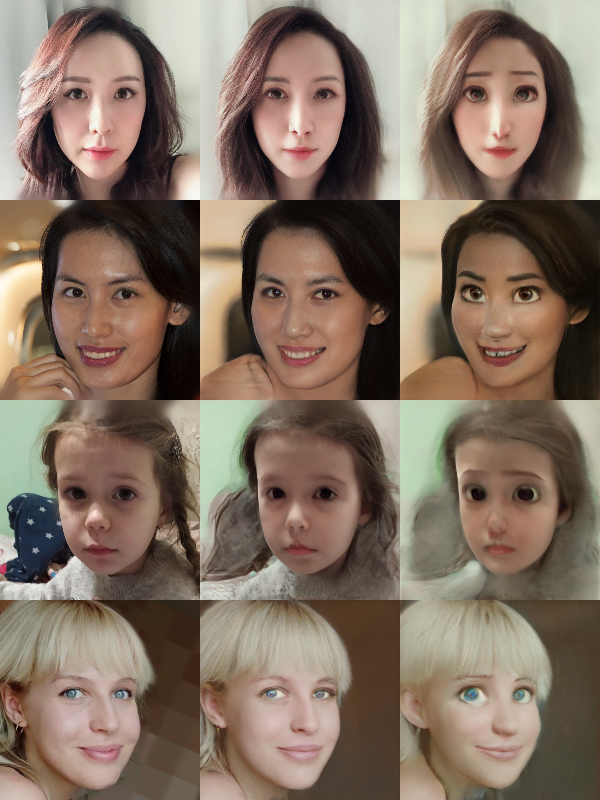

In [ ]:
print(headers)
cv2_imshow(grid)